In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import liana as li
import plotnine as p9

In [3]:
import omnipath as op
import decoupler as dc

In [4]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085

In [5]:
kegg = op.requests.Annotations.get(resources=["KEGG-PC"], entity_types=['protein'])

In [6]:
kegg = kegg[["value", "genesymbol"]].rename({"value": "source", "genesymbol": "target"}, axis=1)
kegg = kegg[["source", "target"]].drop_duplicates()
kegg['target'] = kegg['target'].str.title()

In [7]:
tf_net = dc.get_collectri(organism="mouse")

In [8]:
# Load metabolite receptor interactions
resource =  pd.read_csv('applications/data/MR_brain_20230808.csv')
# resource = dc.translate_net(resource, columns=['receptor'])
resource['receptor'] = resource['receptor'].str.title()
resource.head()

,Unnamed: 0,ligand,receptor
0,1,HMDB0000112,Gabrb2
1,3,HMDB0000216,Adra2B
2,4,HMDB0000068,Adra2B
3,20,HMDB0000148,Grm8
4,49,HMDB0000112,Gabra5


In [9]:
met_net = pd.read_csv("applications/data/PD_processed.csv")
# met_net = dc.translate_net(met_net, columns=['Symbol'])
met_net['Symbol'] = met_net['Symbol'].str.title()
met_net.head()

,Unnamed: 0,HMDB,Symbol,Direction,MetName,Transport,T_direction,Reversibility,DB,Type
0,18524,HMDB0059655,Phgdh,1,2-Hydroxyglutarate,unknown,unknown,irreversible,ReconProductionDegradation,met_est
1,21107,HMDB0006242,Aldh3A1,-1,"3,4-Dihydroxymandelaldehyde",unknown,unknown,irreversible,ReconProductionDegradation,met_est
2,21117,HMDB0000042,Aldh3A1,1,Acetic acid,unknown,unknown,irreversible,ReconProductionDegradation,met_est
3,21116,HMDB0001487,Aldh3A1,1,NADH,unknown,unknown,irreversible,ReconProductionDegradation,met_est
4,21115,HMDB0000663,Aldh3A1,1,Glucaric acid,unknown,unknown,irreversible,ReconProductionDegradation,met_est


In [10]:
resource['metabolite'] = resource['ligand'].map(dict(met_net[['HMDB', 'MetName']].values))

In [11]:
# mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
# rna = mdata.mod["rna"]
# msi = mdata.mod["msi"]

In [12]:
slides = ["A1", "B1", "C1"]

In [13]:
hvg = []
mdatas = {}

for slide in slides:    
    slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"
    mdatas[slide] = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
    msi = mdatas[slide].mod["msi"]
    sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=50)
    
     # annotated which do not contain peak,
    annotated = msi.var['annotated'].astype(str).unique()
    annotated = [a for a in annotated if "peak" not in a]
    
    msk = (msi.var['highly_variable'].values) + (msi.var.index.isin(annotated))
    hvg.append(list(msi.var[msk].index))

In [14]:
from functools import reduce

In [15]:
hvg = reduce(np.union1d, hvg)

In [16]:
interactions = {}
target_metrics = {}

for slide in slides:
    mdata = mdatas[slide]    
    rna = mdata.mod["rna"]
    msi = mdata.mod["msi"]
    
    msi = msi[:, hvg].copy()
    
    # get reference coordinates
    reference = mdata.mod["rna"].obsm["spatial"]
    plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
    li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
    
    # distances of metabolties to RNA
    reference = mdata.mod["msi"].obsm["spatial"]
    li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
    
    dc.run_ulm(rna, net = kegg, use_raw=False, weight=None)
    path = li.ut.obsm_to_adata(rna, "ulm_estimate")
    
    dc.run_ulm(rna, net = tf_net, use_raw=False)
    tfs = li.ut.obsm_to_adata(rna, "ulm_estimate")
    
    receptors = resource[resource['ligand']=='HMDB0000073']['receptor'].values
    receptors = receptors[np.isin(receptors, rna.var.index)]
    receptors = rna[: , receptors].copy()

    # misty
    mdata.update_obs()
    misty = li.mt.MistyData({"intra": msi, "path":path, "tf":tfs, 'receptors':receptors}, enforce_obs=False, obs=mdata.obs)
    misty(model="linear", verbose=True, bypass_intra=True)
    
    interactions[slide] = misty.uns['interactions'].copy()
    target_metrics[slide] = misty.uns['target_metrics'].copy()

view intra is not a csr_matrix. Converting to csr_matrix
view path is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: Tocopherol: 100%|██████████| 110/110 [06:01<00:00,  3.29s/it]             
view intra is not a csr_matrix. Converting to csr_matrix
view path is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: Tocopherol: 100%|██████████| 110/110 [09:03<00:00,  4.94s/it]             
view intra is not a csr_matrix. Converting to csr_matrix
view path is not a csr_matrix. Converting to csr_matrix
view tf is not a csr_matrix. Converting to csr_matrix
Now learning: Tocopherol: 100%|██████████| 110/110 [07:51<00:00,  4.29s/it]             


In [17]:
interactions = pd.concat(interactions).reset_index()
target_metrics = pd.concat(target_metrics).reset_index()

In [18]:
target_metrics.fillna(0, inplace=True)

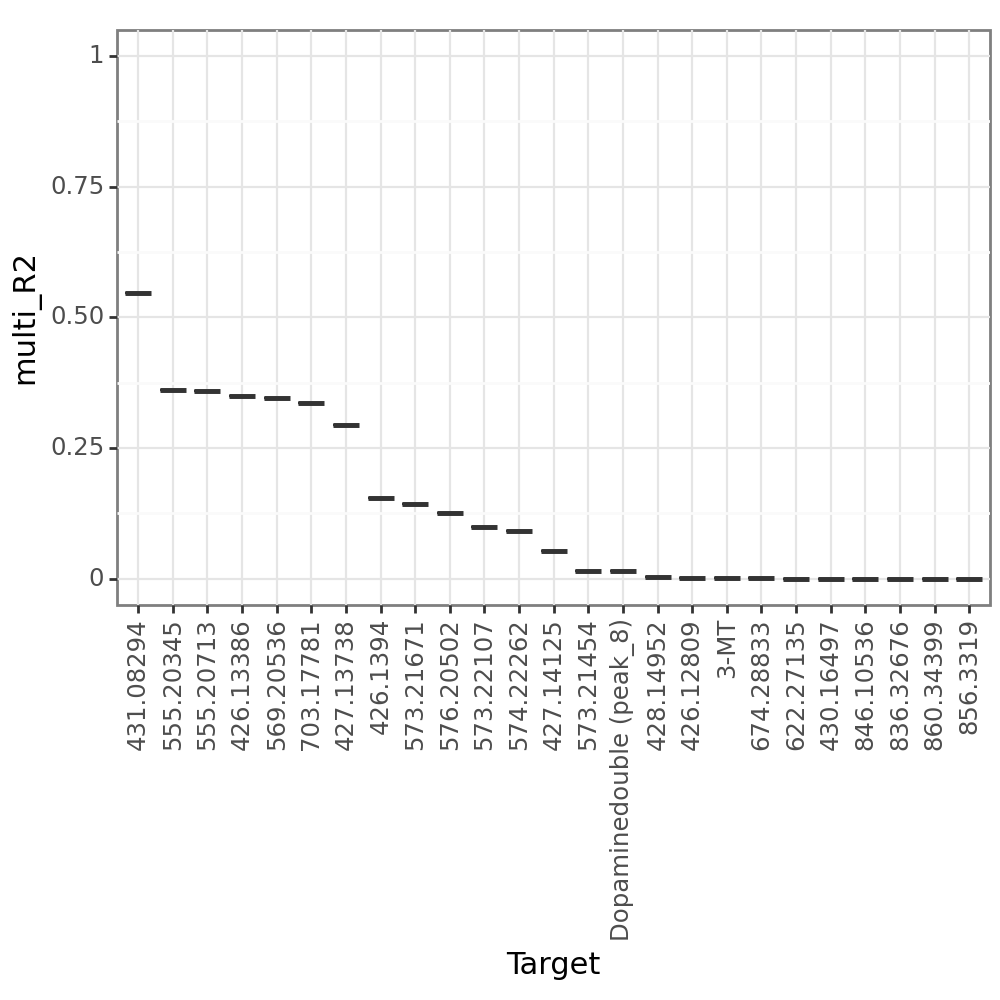

<Figure Size: (500 x 500)>

In [23]:
(
    li.pl.target_metrics(target_metrics=target_metrics, stat='multi_R2', aggregate_fun='mean', top_n=25) +
    # limits
    p9.ylim(0, 1)
)

In [24]:
# check gaba target
target_metrics[target_metrics['target']=='3-MT']

,level_0,level_1,target,intra_R2,multi_R2,gain_R2,path,tf,receptors
17,A1,17,3-MT,0,0.000000,0.000000,0.181196,0.593706,0.225097
127,B1,17,3-MT,0,0.001316,0.001316,0.218198,0.540120,0.241682
237,C1,17,3-MT,0,0.001650,0.001650,0.233310,0.510851,0.255838


In [ ]:
view_names = misty.view_names
view_names.remove('intra')

In [ ]:
view_names

In [ ]:
li.pl.contributions(target_metrics=target_metrics, view_names=view_names, aggregate_fun='median')

One by One

In [ ]:
slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"

HVG

In [ ]:
# sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=500)
# rna = rna[:, rna.var['highly_variable']]

In [ ]:
sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=50)

In [ ]:
# annotated which do not contain peak,
annotated = msi.var['annotated'].astype(str).unique()
annotated = [a for a in annotated if "peak" not in a]

In [ ]:
# highly variable or annotated
msk = (msi.var['highly_variable'].values) + (msi.var.index.isin(annotated))
msi = msi[:, msk].copy()

Test

In [ ]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]


In [ ]:
plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
plot

In [ ]:
# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [ ]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

Funcomics

In [ ]:
dc.run_ulm(rna, net = net, use_raw=False, weight=None)
kegg = li.ut.obsm_to_adata(rna, "ulm_estimate")

In [ ]:
net = dc.get_collectri(organism="mouse")
dc.run_ulm(rna, net = net, use_raw=False)
tfs = li.ut.obsm_to_adata(rna, "ulm_estimate")


Mitsy

In [ ]:
mdata.update_obs()
misty = li.mt.MistyData({"intra": msi, "kegg":kegg, "tf":tfs}, enforce_obs=False, obs=mdata.obs)


In [ ]:
misty(model="linear", verbose=True, bypass_intra=True, maskby='lesion')

In [ ]:
misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)

In [ ]:
# split df by intra group
misty.uns['target_metrics'].groupby("intra_group").apply(lambda x: x.sort_values("gain_R2", ascending=False).head(10))

In [ ]:
# li.pl.target_metrics(misty, stat='gain_R2', top_n=25, return_fig=True)

In [ ]:
most_explained = misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)['target'].values

In [ ]:
(
li.pl.interactions(misty, view='tf', top_n=50, figure_size=(8,5), filterby="intra_group", filter_lambda=lambda x: x=="lesioned") +
p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
)

In [ ]:
sq.pl.spatial_scatter(msi, color=['Dopamine (double)', '3-MT', '431.08294'])

In [ ]:
plt.show()

In [ ]:
sq.pl.spatial_scatter(tfs, color=['Irx1', 'Pou5f1', 'Tfap4', 'Znf335'], cmap='coolwarm', size=1.3)

In [ ]:
plt.show()

In [ ]:
metab = '3-MT' # '551.23688'
misty.uns['interactions'][misty.uns['interactions']['target'] == metab].sort_values("importances", key=abs, ascending=False).head(30)

In [ ]:
# Apply Spatial Smoothing with RNA as reference
w2 = li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", inplace=False, set_diag=False, standardize=False)
rna.layers['smooth'] = w2 @ rna.X

In [ ]:
rna_smooth = rna[:, 'Pdyn'].layers['smooth'].copy()

In [ ]:
sc.AnnData(msi_smooth[:,'Dopamine (double)'].X * rna_smooth.A.flatten())

In [ ]:
import muon as mu

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi_smooth}, obs=rna.obs, uns=rna.uns)

In [ ]:
mdata

In [ ]:
from scipy.sparse import csr_matrix
w3 = np.zeros((mdata.shape[0], mdata.shape[0]))
w3 = csr_matrix(w3)
w3.setdiag(1)
mdata.obsp['spatial_connectivities'] = w3

In [ ]:
mdata

In [ ]:
li.mt.bivar(mdata, function_name='product', x_mod='rna', y_mod='msi', x_layer='smooth', x_use_raw=False, y_use_raw=False, verbose=True, interactions = [('Pdyn', 'Dopamine (double)')])

In [ ]:
mdata.mod['local_scores'].obsm = rna.obsm

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=['Pdyn^Dopamine (double)', 'lesion'])

In [ ]:
plt.show()

In [ ]:
mdata.mod['local_scores'].obs

Metalinks

In [ ]:
from applications._estimate_metalinks import estimate_metalinks

In [ ]:
# estimate metabolites
metalinks = estimate_metalinks(rna, resource=resource, met_net=met_net, consider_transport=True, min_n=3)

In [ ]:
metalinks.mod['metabolite'].var

In [ ]:
act = pd.DataFrame([metalinks.mod['metabolite'].X.mean(axis=0)], columns= metalinks.mod['metabolite'].var.index)

In [ ]:
obs = pd.DataFrame([rna.X.mean(axis=0).A.flatten()], columns=rna.var.index)

In [ ]:
met_net.rename({"Symbol": "target", "HMDB":"source"}, axis=1, inplace=True)

In [ ]:
met_net = met_net[met_net['source']=="HMDB0000073"]
met_net = met_net[met_net['target'].isin(rna.var.index)]

In [ ]:
met_net